# Exercise 3.11

Use OSMnx to download the shapes of all pharmacies in Pisa
* Plot in folium the shape of the municipality of Pisa and the pharmacies with a pop-up showing their name
* Compute the distance of each of these pharmacies to the Department of Computer Science (DPC) and to the CNR.
* Compute and visualize the pedestrian shortest path from DPC and its closest pharmacy. Do the same for CNR.
* Submit a (well documented) notebook.

## Importing the Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np

import skmob
import folium
import random

import urllib.request

import osmnx as ox
from shapely.geometry import *

## Plotting the shape of Pisa and the Starting Points
Plus the shapes of the surrounding areas I considered for the scope of the exercise

In [2]:
def flip_xy(point): #writing a simple function to avoid putting always the inverse coordinates of a point in folium
    return point.y, point.x

def get_centroid(geometry): #it's because of the constant warning, so that I get a centroid without it
    return geometry.to_crs('+proj=cea').centroid.to_crs('epsg:4326')

In [3]:
#I decided to include the nearest cities because they are very close to the CNR and it may be closer to go to a pharmacy there
place = ['Pisa, Italy', 'San Giuliano Terme, Italy', 'Cascina, Italy']
gdf = ox.geocode_to_gdf(place) #collecting the shapes and converting them to a gdf

In [4]:
cs_dep = ox.geocode_to_gdf('Polo Fibonacci, Via Filippo Buonarroti, Pisa, Italy', which_result=1)
cs_dep

geometry  bbox_north  bbox_south  \
0  POLYGON ((10.40740 43.72006, 10.40744 43.72003...   43.722439    43.71945   

   bbox_east  bbox_west   place_id osm_type     osm_id        lat        lon  \
0  10.409174    10.4074  158648143      way  217538423  43.721167  10.408215   

                                        display_name    class        type  \
0  Polo Fibonacci, Via Filippo Buonarroti, San Fr...  amenity  university   

   importance  
0      0.7201

In [5]:
cnr = ox.geocode_to_gdf('Consiglio Nazionale delle Ricerche (CNR), Pisa', which_result=1)
cnr

geometry  bbox_north  bbox_south  \
0  POLYGON ((10.42048 43.71906, 10.42062 43.71893...   43.719948   43.717123   

   bbox_east  bbox_west   place_id  osm_type   osm_id        lat        lon  \
0  10.423939  10.420483  298058236  relation  1706322  43.718535  10.422051   

                                        display_name     class type  \
0  Consiglio Nazionale delle Ricerche (CNR), Via ...  building  yes   

   importance  
0      0.6101

In [6]:
#storing the two points of reference for the exercise in a single gpd
spois = gpd.GeoDataFrame(pd.concat((cs_dep, cnr), ignore_index=True))

In [ ]:
#setting the starting location of the map at the center between the cnr and the cs dep
cs_dep_cent = get_centroid(cs_dep)
cnr_cent = get_centroid(cnr)

#doing a series of conversion from linestring to centroid, from eq area projection to WGS 84
start_loc = gpd.GeoDataFrame(geometry=[
                                       LineString([cs_dep_cent[0], cnr_cent[0]]).centroid],
                             crs='epsg:4326')['geometry']
                             

map_f = folium.Map(location=flip_xy(start_loc[0]), zoom_start=15)
folium.GeoJson(gdf['geometry']).add_to(map_f) #adding the geometry of the cities to the map

#here I looped through the rows coloring green the points from which to start the route
for _, spoi in spois.iterrows():
    folium.GeoJson(spoi['geometry'], 
                   style_function= lambda x :{'color':'green', 'fillColor':'green'}
                  ).add_to(map_f) #adding the geometry of the cs departement and cnr in green

#visualizing the result
map_f

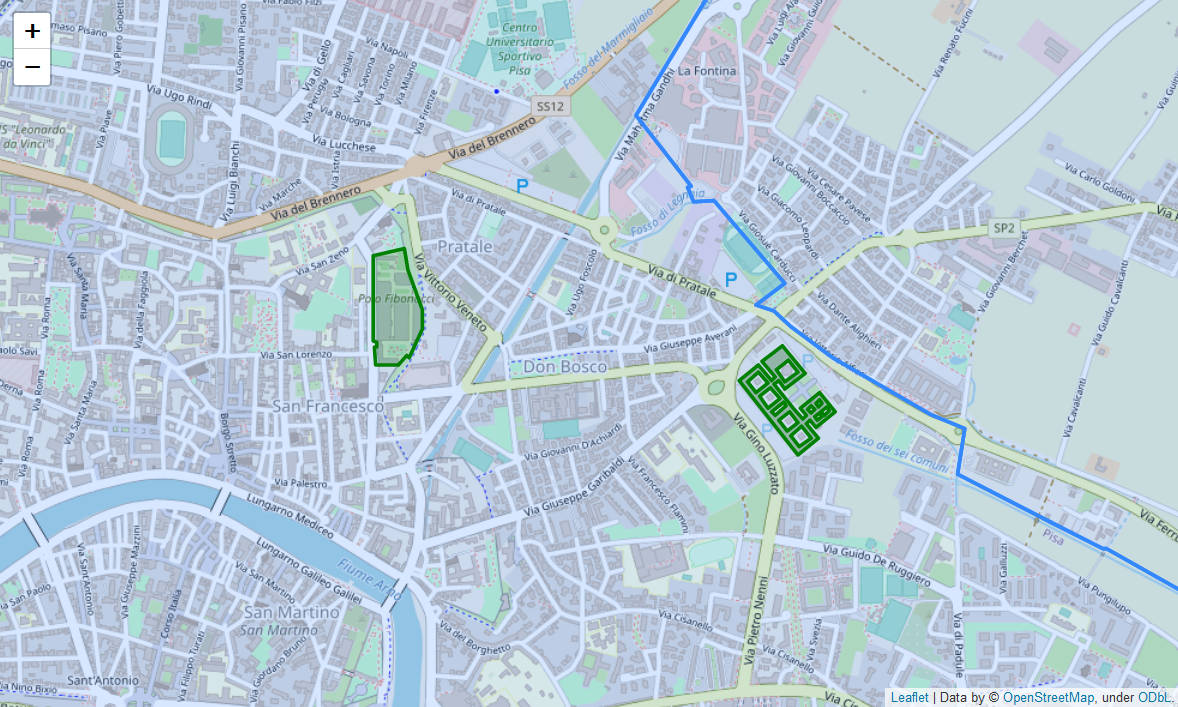

## Getting the Pharmacies of Pisa

In [8]:
tags = {'amenity': 'pharmacy'}
pharmacies = ox.geometries_from_place(place, tags) #getting the pharmacies with place and tag
pharmacies.head()

amenity healthcare                           name  \
element_type osmid                                                           
node         245802472  pharmacy   pharmacy          Centro "Le Querciole"   
             262365285  pharmacy   pharmacy  Farmacia Titignano di Cascina   
             364741609  pharmacy   pharmacy                          Petri   
             366621687  pharmacy   pharmacy          Farmacia Comunale n°5   
             602086093  pharmacy   pharmacy                Farmacia Macchi   

                                         geometry addr:city addr:housenumber  \
element_type osmid                                                             
node         245802472  POINT (10.44970 43.72454)       NaN              NaN   
             262365285  POINT (10.46046 43.69179)       NaN              NaN   
             364741609  POINT (10.40136 43.71485)      Pisa                1   
             366621687  POINT (10.39223 43.72340)      Pisa               6A   
             602086093  POINT (10.39993 43.77539)       NaN              NaN   

                       addr:postcode                    addr:street  \
element_type osmid                                                    
node         245802472           NaN                            NaN   
             262365285           NaN                            NaN   
             364741609         56125                   Corso Italia   
             366621687         56122  Via Giovan Battista Niccolini   
             602086093           NaN                            NaN   

                       dispensing drive_through  ...  \
element_type osmid                               ...   
node         245802472        NaN           NaN  ...   
             262365285        NaN           NaN  ...   
             364741609        yes            no  ...   
             366621687        NaN            no  ...   
             602086093        NaN           NaN  ...   

                                             source wheelchair addr:country  \
element_type osmid                                                            
node         245802472                          NaN        NaN          NaN   
             262365285                          NaN        NaN          NaN   
             364741609                          NaN        NaN          NaN   
             366621687  PCN aerial 2006;Bing aerial        NaN          NaN   
             602086093                          NaN        NaN          NaN   

                       contact:housenumber contact:street contact:city  \
element_type osmid                                                       
node         245802472                 NaN            NaN          NaN   
             262365285                 NaN            NaN          NaN   
             364741609                 NaN            NaN          NaN   
             366621687                 NaN            NaN          NaN   
             602086093                 NaN            NaN          NaN   

                       contact:postcode nodes building building:levels  
element_type osmid                                                      
node         245802472              NaN   NaN      NaN             NaN  
             262365285              NaN   NaN      NaN             NaN  
             364741609              NaN   NaN      NaN             NaN  
             366621687              NaN   NaN      NaN             NaN  
             602086093              NaN   NaN      NaN             NaN  

[5 rows x 26 columns]

In [9]:
#seeing if some points do not have a name
pharmacies[pharmacies['name'].isna()]['geometry']

element_type  osmid     
node          1944700511    POINT (10.38327 43.70771)
              8069747019    POINT (10.41248 43.73804)
Name: geometry, dtype: geometry

In [10]:
#adding the name of the only missing pharmacies
pharmacies.loc[pharmacies['geometry'] == Point((10.38327, 43.70771)) ,'name'] = 'Parafarmacia Sanac'
#dropping the other pharmacy as it's not a pharmacy but a veterinary
pharmacies = pharmacies.drop(pharmacies[pharmacies['name'].isna()].index)

In [11]:
pharmacies.head()

amenity healthcare                           name  \
element_type osmid                                                           
node         245802472  pharmacy   pharmacy          Centro "Le Querciole"   
             262365285  pharmacy   pharmacy  Farmacia Titignano di Cascina   
             364741609  pharmacy   pharmacy                          Petri   
             366621687  pharmacy   pharmacy          Farmacia Comunale n°5   
             602086093  pharmacy   pharmacy                Farmacia Macchi   

                                         geometry addr:city addr:housenumber  \
element_type osmid                                                             
node         245802472  POINT (10.44970 43.72454)       NaN              NaN   
             262365285  POINT (10.46046 43.69179)       NaN              NaN   
             364741609  POINT (10.40136 43.71485)      Pisa                1   
             366621687  POINT (10.39223 43.72340)      Pisa               6A   
             602086093  POINT (10.39993 43.77539)       NaN              NaN   

                       addr:postcode                    addr:street  \
element_type osmid                                                    
node         245802472           NaN                            NaN   
             262365285           NaN                            NaN   
             364741609         56125                   Corso Italia   
             366621687         56122  Via Giovan Battista Niccolini   
             602086093           NaN                            NaN   

                       dispensing drive_through  ...  \
element_type osmid                               ...   
node         245802472        NaN           NaN  ...   
             262365285        NaN           NaN  ...   
             364741609        yes            no  ...   
             366621687        NaN            no  ...   
             602086093        NaN           NaN  ...   

                                             source wheelchair addr:country  \
element_type osmid                                                            
node         245802472                          NaN        NaN          NaN   
             262365285                          NaN        NaN          NaN   
             364741609                          NaN        NaN          NaN   
             366621687  PCN aerial 2006;Bing aerial        NaN          NaN   
             602086093                          NaN        NaN          NaN   

                       contact:housenumber contact:street contact:city  \
element_type osmid                                                       
node         245802472                 NaN            NaN          NaN   
             262365285                 NaN            NaN          NaN   
             364741609                 NaN            NaN          NaN   
             366621687                 NaN            NaN          NaN   
             602086093                 NaN            NaN          NaN   

                       contact:postcode nodes building building:levels  
element_type osmid                                                      
node         245802472              NaN   NaN      NaN             NaN  
             262365285              NaN   NaN      NaN             NaN  
             364741609              NaN   NaN      NaN             NaN  
             366621687              NaN   NaN      NaN             NaN  
             602086093              NaN   NaN      NaN             NaN  

[5 rows x 26 columns]

In [12]:
for _, pharma in pharmacies.iterrows():
    folium.Marker(flip_xy(pharma['geometry'].centroid), #the location of the marker
                  popup=pharma['name'], #its name
                  icon=folium.Icon(color='red') #the color of the icon
                 ).add_to(map_f)

In [ ]:
# visualizing the current result
map_f

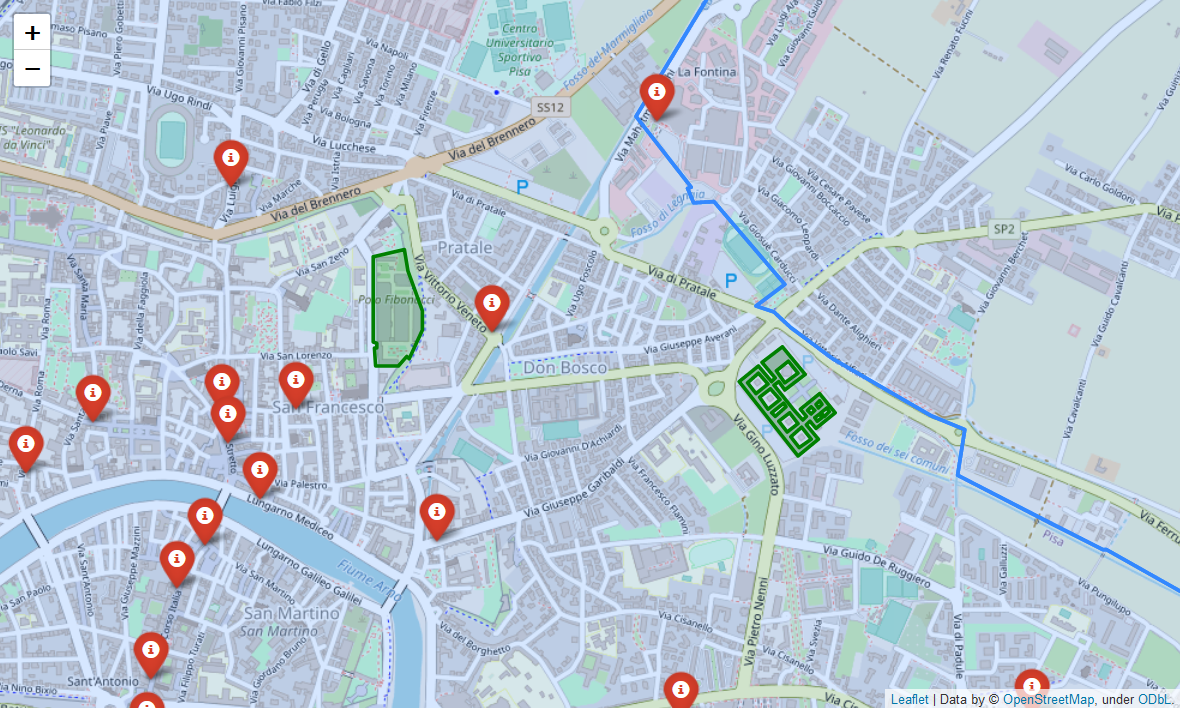

## Computing the Earth Distances 

In [14]:
#I already written this in a previous exercise (1.1 if I'm not wrong)

from math import cos, sin, asin, sqrt, pi, tan

def to_radians(*args): #I needed radians to work with trigonometry
    for raw in args:
        yield raw*(pi/180) #I made it a generator out of convenience

def haversine_formula(P, Q):
    latP, lonP = P
    latQ, lonQ = Q
    #converting the latitude and longitudes to radians
    latP, lonP, latQ, lonQ = tuple(to_radians(latP, lonP, latQ, lonQ))
    #print(latP, lonP, latQ, lonQ)

    earth_radius = 6371000 #m, from wikipedia

    Dlat = latQ - latP
    Dlon = lonQ - lonP

    #I copied and translated the formula to python
    to_sqrt = sin(Dlat/2)**2 + cos(latP)*cos(latQ)*sin(Dlon/2)**2
    d = 2*earth_radius*asin(sqrt(to_sqrt))

    return  d

In [15]:
# looping through the row of the list of pharmacies twice,
distances = list()
for _, spoi in spois.iterrows():
    per_spoi = list()
    for _, pharma in pharmacies.iterrows():
        dist = haversine_formula(flip_xy(spoi['geometry'].centroid), 
                                 flip_xy(pharma['geometry'].centroid))
        per_spoi.append((pharma['name'], dist))
    #adding to a list a tuple with the centroid/point in space, name of the starting point and that of the pharmacies with dist.
    distances.append((spoi['display_name'], per_spoi, spoi['geometry'].centroid)) 

In [16]:
for spoi in distances:
    closest = min(spoi[1], key=lambda x: x[1]) 
    print(f'Closest pharmacy to {spoi[0]} is:\n', 
          closest[0], f'with a distance of {closest[1]:.2f} meters', end='\n\n')

Closest pharmacy to Polo Fibonacci, Via Filippo Buonarroti, San Francesco, Pisa, Tuscany, 56127, Italy is:
 Farmacia Comunale n°3 with a distance of 283.89 meters

Closest pharmacy to Consiglio Nazionale delle Ricerche (CNR), Via Pietro Colletta, San Giuliano Terme, Pisa, Tuscany, 56124, Italy is:
 Farmacia Comunale n°3 with a distance of 872.42 meters



## Computing the pedestrian shortest path

In [17]:
#DOWNLOADING THE ROAD NETWORK
G = ox.graph_from_place(place, network_type="walk")

In [19]:
#converting the point to equal area to compute centroid and then back to the standard
#the first is the cs departement, the second the cnr
starting_points = get_centroid(spois)
#the farmacy's order is the same
dest_points = get_centroid(pharmacies)

per_spoi = list()
for spoi in starting_points:
    per_dest = list()
    for destinatio in dest_points:
        #setting the origin as the cs dep or the cnr
        orig = ox.distance.nearest_nodes(G, X=spoi.x, Y=spoi.y)
        dest = ox.distance.nearest_nodes(G, X=destinatio.x, Y=destinatio.y)
        
        # find the shortest path between nodes, minimizing travel time
        route = ox.shortest_path(G, orig, dest, weight="travel_time")
        
        #computing how long is the route in meters
        edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
        dist = sum(edge_lengths)
        
        #appending the result to the list of the current starting point, adding also the route to plot it later
        per_dest.append((dist, route))
        
    #appending the current starting point list to the main list
    per_spoi.append(per_dest)

## Result

For the <b>CS departement</b> the closest pharmacy is the same evidenced by the earth distance: <b>Farmacia Comunale n°3</b>

Contrary to earth distance, for the <b>CNR</b>, the distance computed with the shortest walking path to the closest pharmacy resulted in a different pharmacy in San Giuliano Terme: <b>Farmacia comunale La Fontina</b>

In [20]:
#creating a main list to use later to plot the route
origin_names = ['Computer Science Dep.', 'CNR'] #I will use it to name the places here and in the next plots
data_x_plot = list()

for n, x in enumerate(per_spoi):
    #minimum distance according to the first element of the pair (dist, route)
    min_dist_route = min(x, key=lambda x: x[0])
    #getting the index of the minimum distance
    index_min_dist = x.index(min_dist_route)
    #selecting only the minimum distance (excluding the route from the variable min_dist_route)
    min_dist = min_dist_route[0]
    
    #selecting the corresponding closest farmacy according to the index
    corresp_pharma = pharmacies['name'].tolist()[index_min_dist]
    
    print('The', origin_names[n], 
          'is closest to:', corresp_pharma, 
          f'with a distance of: {min_dist:.2f} meters')
    
    #appending everthing to a list (I will use it to plot)
    data_x_plot.append((origin_names[n], #0
                        index_min_dist, #1
                        min_dist_route[1] #2
                       ))

The Computer Science Dep. is closest to: Farmacia Comunale n°3 with a distance of: 563.61 meters
The CNR is closest to: Farmacia comunale La Fontina with a distance of: 1287.08 meters


## Visualizing the Results

In [21]:
#to select the the names and the centroids from a single source
pharm_centroid = gpd.GeoDataFrame(pharmacies['name'].values, columns = ['name'],
                                  geometry=get_centroid(pharmacies['geometry']).values)

In [ ]:
#plotting the route fom the cs departement

n = 0 #used to copy again the code later
idx = data_x_plot[n][1] #index of the minimum distance pharmacy
route_from = data_x_plot[n][2] #shortest route to the closest pharmacy

final_map = ox.plot_route_folium(G, route_from)

#adding the building of the starting point
folium.GeoJson(spois['geometry'][n], 
               style_function= lambda x :{'color':'green', 'fillColor':'green'}
              ).add_to(final_map) #adding the geometry of the cs departement

#adding a marker to signal the start of the path
folium.Marker(flip_xy(spois['geometry'][n].centroid), #adding the starting point
              popup=f'Start from {origin_names[n]}', 
              icon=folium.Icon(color='green')).add_to(final_map)

#adding a marker to signal the end of the path
folium.Marker(location=flip_xy(pharm_centroid['geometry'][idx]), #adding the end point
              popup=f'End to {pharm_centroid["name"][idx]}',
              icon=folium.Icon(color='red')).add_to(final_map)
final_map

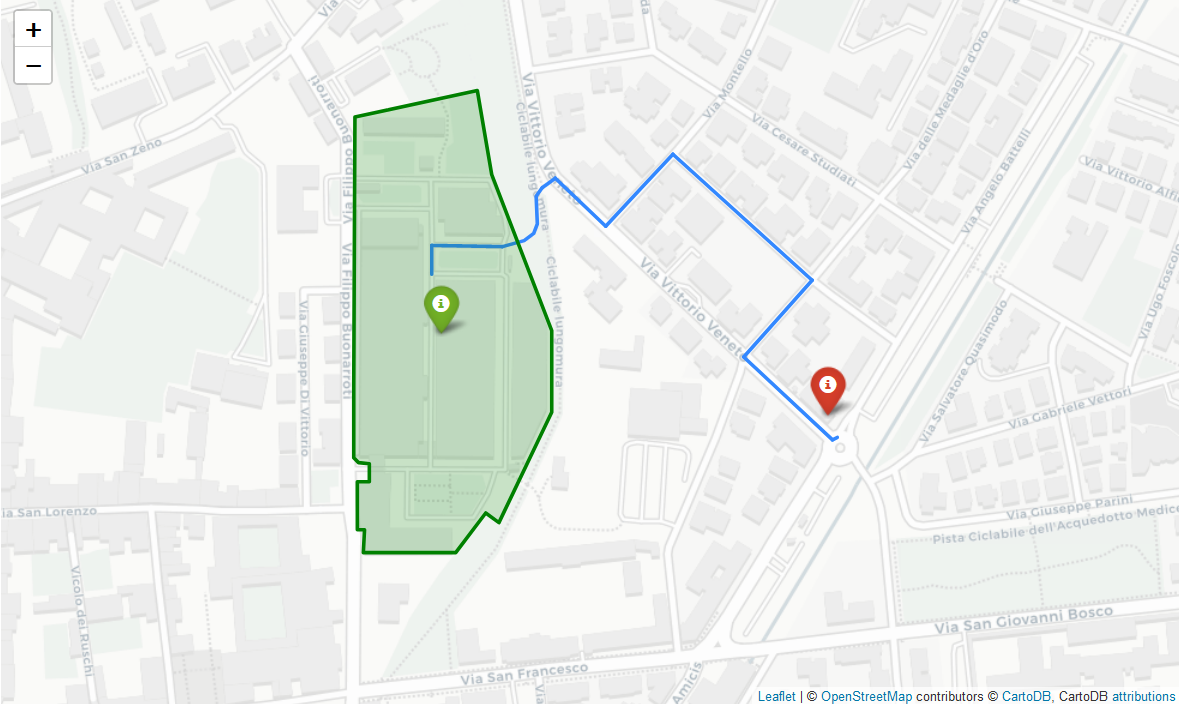

In [ ]:
#plotting the route fom the cnr

n = 1
idx = data_x_plot[n][1] #index of the minimum distance pharmacy
route_from = data_x_plot[n][2] #shortest route to the closest pharmacy

final_map = ox.plot_route_folium(G, route_from)

#adding the building of the starting point
folium.GeoJson(spois['geometry'][n], 
               style_function= lambda x :{'color':'green', 'fillColor':'green'}
              ).add_to(final_map) #adding the geometry of the cs departement

#adding a marker to signal the start of the path
folium.Marker(flip_xy(spois['geometry'][n].centroid), #adding the starting point
              popup=f'Start from {origin_names[n]}', 
              icon=folium.Icon(color='green')).add_to(final_map)

#adding a marker to signal the end of the path
folium.Marker(location=flip_xy(pharm_centroid['geometry'][idx]), #adding the end point
              popup=f'End to {pharm_centroid["name"][idx]}',
              icon=folium.Icon(color='red')).add_to(final_map)
final_map

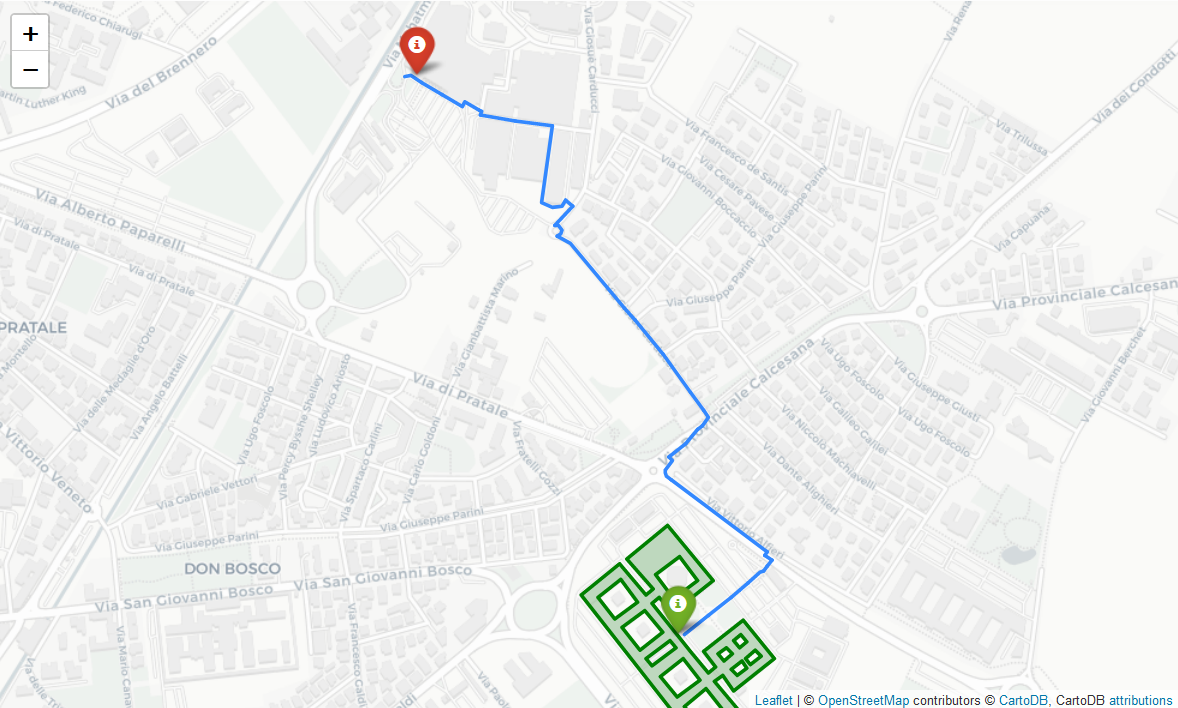